In [314]:
#libraries
library(tidyverse)
library(RColorBrewer)
library(showtext)
library(dplyr)

Loading required package: sysfonts



Loading required package: showtextdb



In [11]:
path_files <- "C://Users//jziac//OneDrive//Documents//programovani//projekty//elite//data//data_report//"

In [12]:
file_name <- "nhl_player_stats.csv"

In [263]:
#graphics set up
gg_size <- 11
plot_size <- 7
size_multiplier <- 2
options(repr.plot.width=plot_size*size_multiplier, repr.plot.height=plot_size*size_multiplier)
def_plot_setup <- theme_light() + 
theme(text=element_text(size=gg_size*size_multiplier,  family="sans"))
my_colours <- brewer.pal(n=9,"Paired")

In [95]:
create_comparative_measure <- function(df, position, reg_seas, stat){
if(position=="defense"){
    match <- "D"
}
else if(position=="attack"){
    match <-"W|C"
}
else if(position=="all"){
    match <- "W|C|D"
}

season_values <- df %>%
filter(grepl(match, position)) %>%
filter(regular_season==reg_seas) %>%
group_by(season) %>%
summarize(mad = mad({{stat}}, na.rm=TRUE), median = median({{stat}}, na.rm=TRUE), median_games = median(gp))

dominance_df <- player_data %>%
filter(grepl(match, position)) %>%
filter(regular_season==reg_seas) %>%
left_join(season_values, by="season") %>%
filter(gp > median_games) %>%
mutate(measure=({{stat}}-median)/mad) %>%
arrange(desc(measure))  %>%
select(name, position, active, gp, g, a, tp, plus_minus, season, team_id, nationality, avg_p, avg_g, mad, median, median_games, measure, season_id) 
dominance_df$rank <- 1:nrow(dominance_df)
dominance_df <- dominance_df %>%
relocate(rank)

dominance_df
}

create_career_measure<-function(df){
career_measure <- df %>%
group_by(name) %>%
summarize(measure=mean(measure), n= n()) %>%
filter(n > median(n))  %>%
arrange(desc(measure))
career_measure
}

In [32]:
#constants
big_six <- c("Sweden", "Canada", "Russia", "Czechia", "Finland", "Canada", "USA")

In [29]:
player_data <- read_csv(paste(path_files, file_name, sep=""))
player_data <- player_data %>%
mutate(season_id = season_id - min(season_id) + 1) %>%
mutate(avg_g=g/gp, avg_p=tp/gp)
head(player_data)

New names:
* `id` -> `id...1`
* `id` -> `id...19`
* `id` -> `id...32`
* `id` -> `id...34`
Rows: 91990 Columns: 35
-- Column specification --------------------------------------------------------
Delimiter: ","
chr   (7): name, position, handedness, contract_end, captaincy, nationality,...
dbl  (26): id...1, u_id, active, age, cap_hit, signed_nhl, drafted, height, ...
lgl   (1): catches
date  (1): date_birth

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


id...1,u_id,name,position,active,age,handedness,catches,contract_end,cap_hit,...,a,tp,pm,plus_minus,id...32,nationality,id...34,season,avg_g,avg_p
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<lgl>,<chr>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
1,9165,David Gove,LW/C,0,NA,L,NA,NA,NA,...,NA,NA,NA,NA,1,USA,120,2005-2006,NA,NA
1,9165,David Gove,LW/C,0,NA,L,NA,NA,NA,...,1,1,0,2,1,USA,120,2005-2006,0,1
1,9165,David Gove,LW/C,0,NA,L,NA,NA,NA,...,NA,NA,NA,NA,1,USA,121,2006-2007,NA,NA
1,9165,David Gove,LW/C,0,NA,L,NA,NA,NA,...,0,0,0,0,1,USA,121,2006-2007,0,0
2,9657,Konstantin Pushkaryov,RW/LW,1,38,L,NA,NA,NA,...,NA,NA,NA,NA,2,Kazakhstan,120,2005-2006,NA,NA
2,9657,Konstantin Pushkaryov,RW/LW,1,38,L,NA,NA,NA,...,1,1,0,0,2,Kazakhstan,120,2005-2006,0,1


In [30]:
season_regular_counts <- player_data %>%
filter(regular_season==1 & gp != 0) %>%
count(season_id, name="count_o") 
season_playoff_counts <- player_data %>%
filter(regular_season==0 & gp != 0) %>%
count(season_id, name="count_o") 



# Analysis of NHL Seasons from 1917 to 2023

## Nationalities Shares of Players

In [101]:
font_add(familiy="Calibri", regular='Calibri.ttf')

ERROR: Error in font_add(familiy = "Calibri", regular = "Calibri.ttf"): could not find function "font_add"


Warning message:
"Removed 6 rows containing missing values (`geom_line()`)."


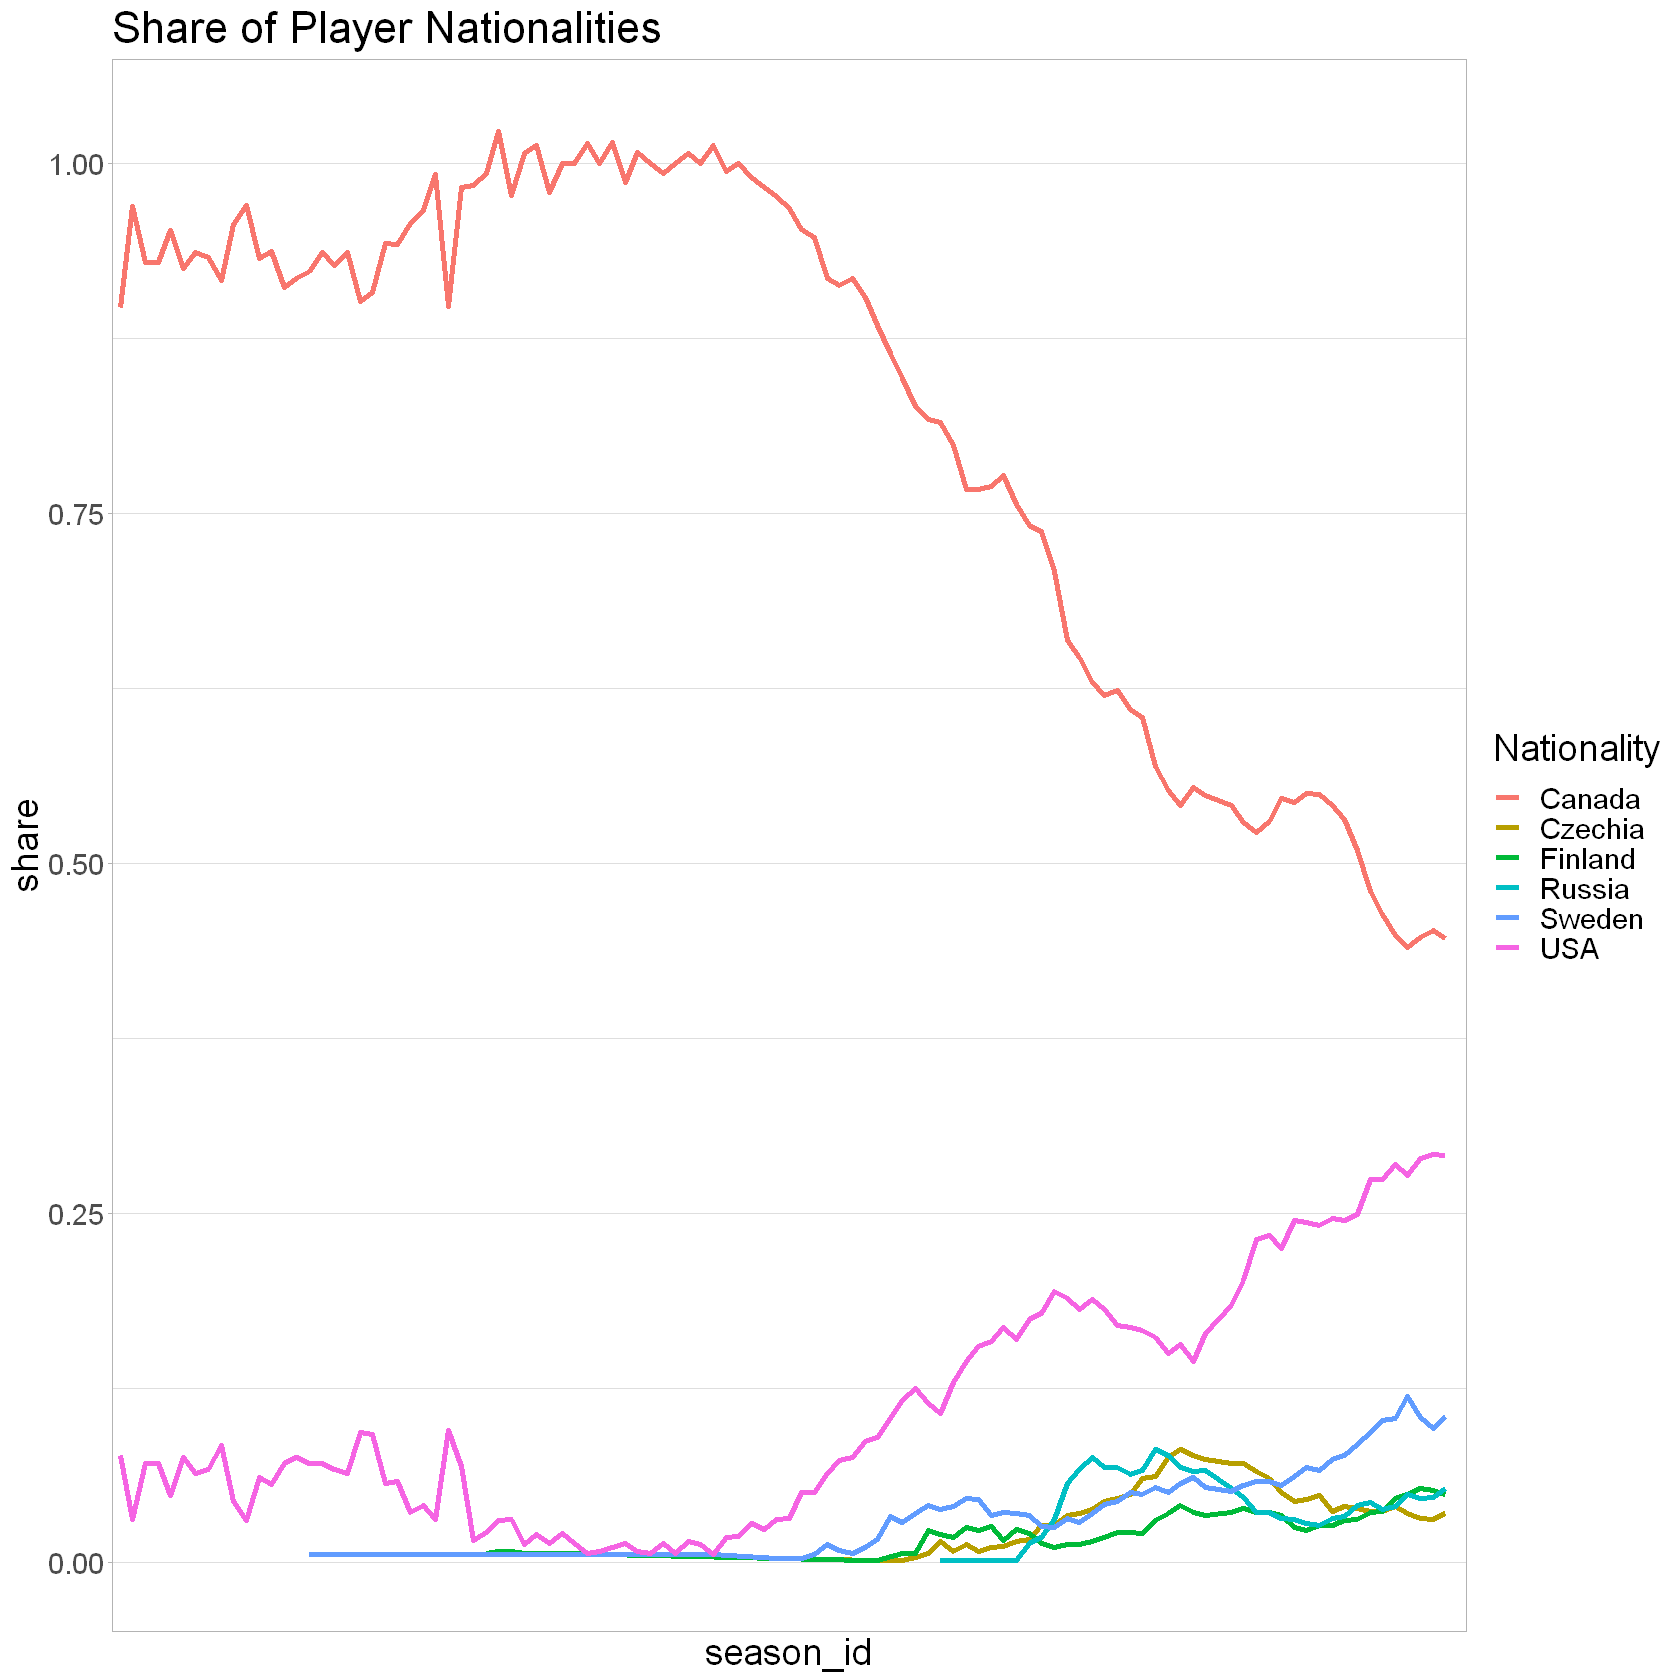

In [264]:
player_data %>%
filter(regular_season==1) %>%
count(season_id, nationality) %>%
left_join(season_regular_counts, by="season_id") %>%
filter(nationality %in% big_six) %>%
mutate(share = round(n/count_o, 3)) %>%
ggplot(., aes(x=season_id, y=share, color=nationality)) +
geom_line(size=1.5) + 
labs(title= "Share of Player Nationalities", color="Nationality") +
scale_x_discrete(breaks=1:12, labels = 1:12) + 
scale_fill_manual(values=my_colours) +
def_plot_setup



Warning message:
"Removed 2 rows containing missing values (`geom_line()`)."


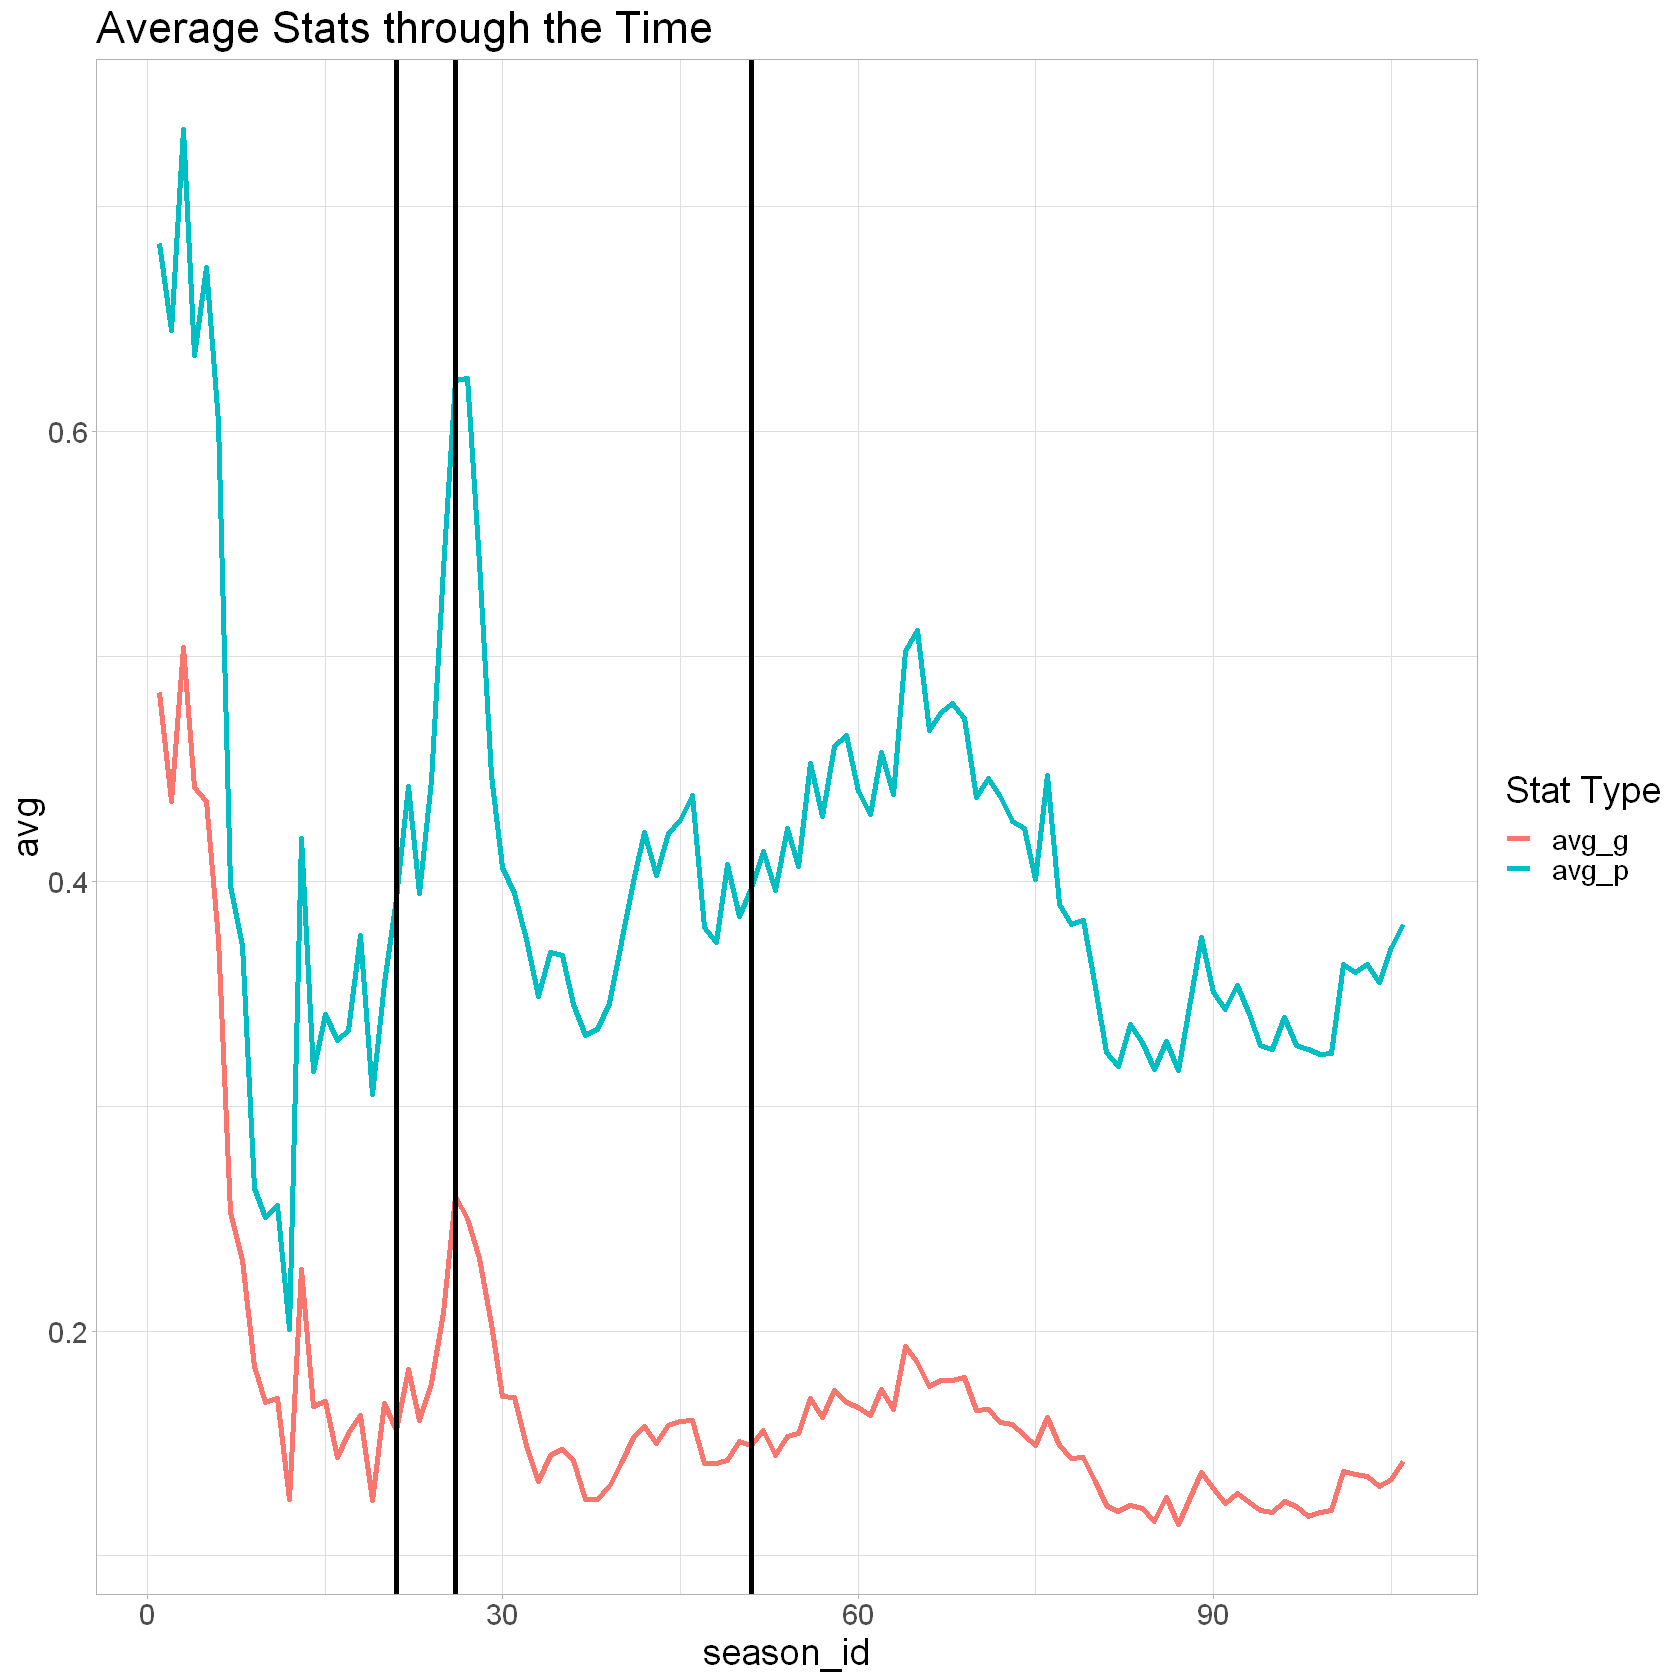

In [265]:
player_data %>%
filter(regular_season==1) %>%
group_by(season_id) %>%
summarize(avg_g = mean(avg_g, na.rm=TRUE), avg_p = mean(avg_p, na.rm=TRUE)) %>%
pivot_longer(!season_id, names_to="type_stat", values_to="avg") %>%
ggplot(., aes(x=season_id, y=avg, colour=type_stat)) +
geom_line(size=1.5) + 
labs(title= "Average Stats through the Time", color="Stat Type") +
geom_vline(xintercept=21, size = 1.5) +
geom_vline(xintercept=26, size = 1.5) +
geom_vline(xintercept=51, size = 1.5) + 
scale_fill_manual(values=my_colours) +
def_plot_setup 

### Dominant Player Performances

#### Distribution of Seasonal Points Per Game

Warning message:
"Removed 1146 rows containing non-finite values (`stat_density()`)."


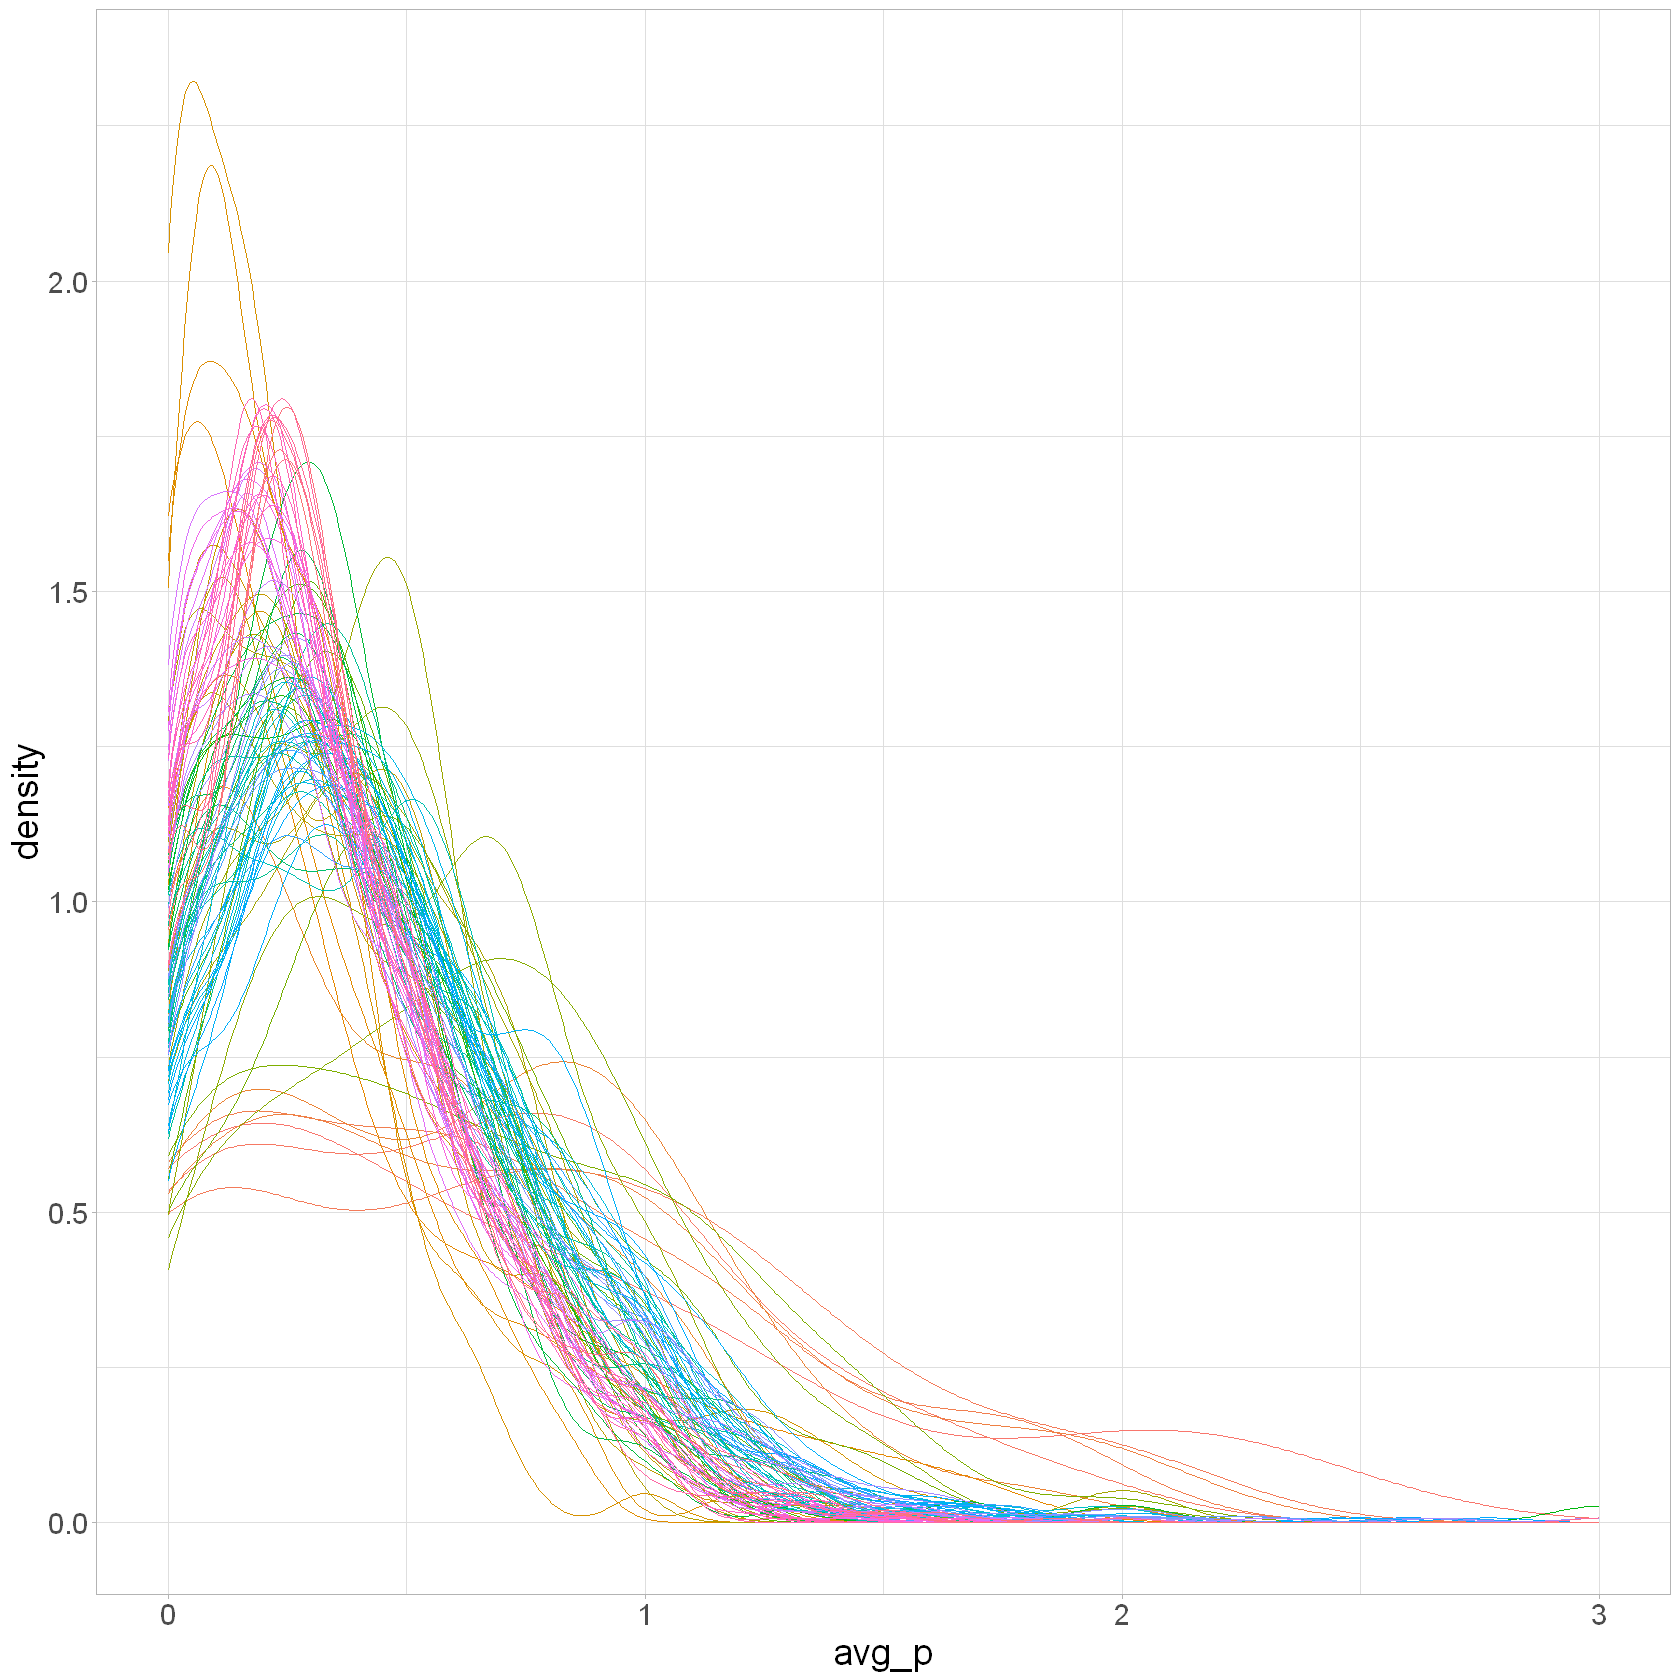

In [127]:
data %>%
filter(regular_season==1) %>%
ggplot(., aes( x=avg_p, colour=season)) + 
geom_density() + 
def_plot_setup + 
theme(legend.position='none') 

#### Points Per Game - Forwards

##### Best Seasons

In [260]:
dominance_p_f <- create_comparative_measure(data, "attack", 1, avg_p)
head(dominance_p_f, 10)


rank,name,position,active,gp,g,a,tp,plus_minus,season,team_id,nationality,avg_p,avg_g,mad,median,median_games,measure,season_id
<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Mario Lemieux,C,0,60,69,91,160,55,1992-1993,81,Canada,2.666667,1.1500000,0.3212300,0.4000000,54.0,7.056211,76
2,Wayne Gretzky,C,0,74,87,118,205,78,1983-1984,66,Canada,2.770270,1.1756757,0.3515320,0.4871051,56.0,6.494900,67
3,Wayne Gretzky,C,0,80,73,135,208,100,1984-1985,66,Canada,2.600000,0.9125000,0.3611462,0.5000000,57.0,5.814820,68
4,Mario Lemieux,C,0,70,69,92,161,10,1995-1996,81,Canada,2.300000,0.9857143,0.3357133,0.3802817,49.0,5.718326,79
5,Connor McDavid,C,1,56,33,72,105,21,2020-2021,66,Canada,1.875000,0.5892857,0.2685313,0.3402128,38.0,5.715488,104
6,Wayne Gretzky,C,0,80,52,163,215,71,1985-1986,66,Canada,2.687500,0.6500000,0.3828025,0.5081967,55.0,5.693023,69
7,Mario Lemieux,C,0,76,85,114,199,41,1988-1989,81,Canada,2.618421,1.1184211,0.3883000,0.4285714,49.0,5.639582,72
8,Wayne Gretzky,C,0,80,92,120,212,80,1981-1982,66,Canada,2.650000,1.1500000,0.3857414,0.5714286,51.5,5.388510,65
9,Wayne Gretzky,C,0,80,71,125,196,61,1982-1983,66,Canada,2.450000,0.8875000,0.3706500,0.5000000,60.0,5.261028,66


##### Career Highs

In [261]:
career_p_dominance_f <- create_career_measure(dominance_p_f)
head(career_p_dominance_f, 10)

name,measure,n
<chr>,<dbl>,<int>
Mario Lemieux,4.445739,11
Connor McDavid,4.372629,7
Wayne Gretzky,4.228089,18
Leon Draisaitl,3.244272,8
Sidney Crosby,3.127331,14
Nikita Kucherov,3.053716,7
Peter Forsberg,2.956637,8
Yevgeni Malkin,2.956521,13
Artemi Panarin,2.928784,8


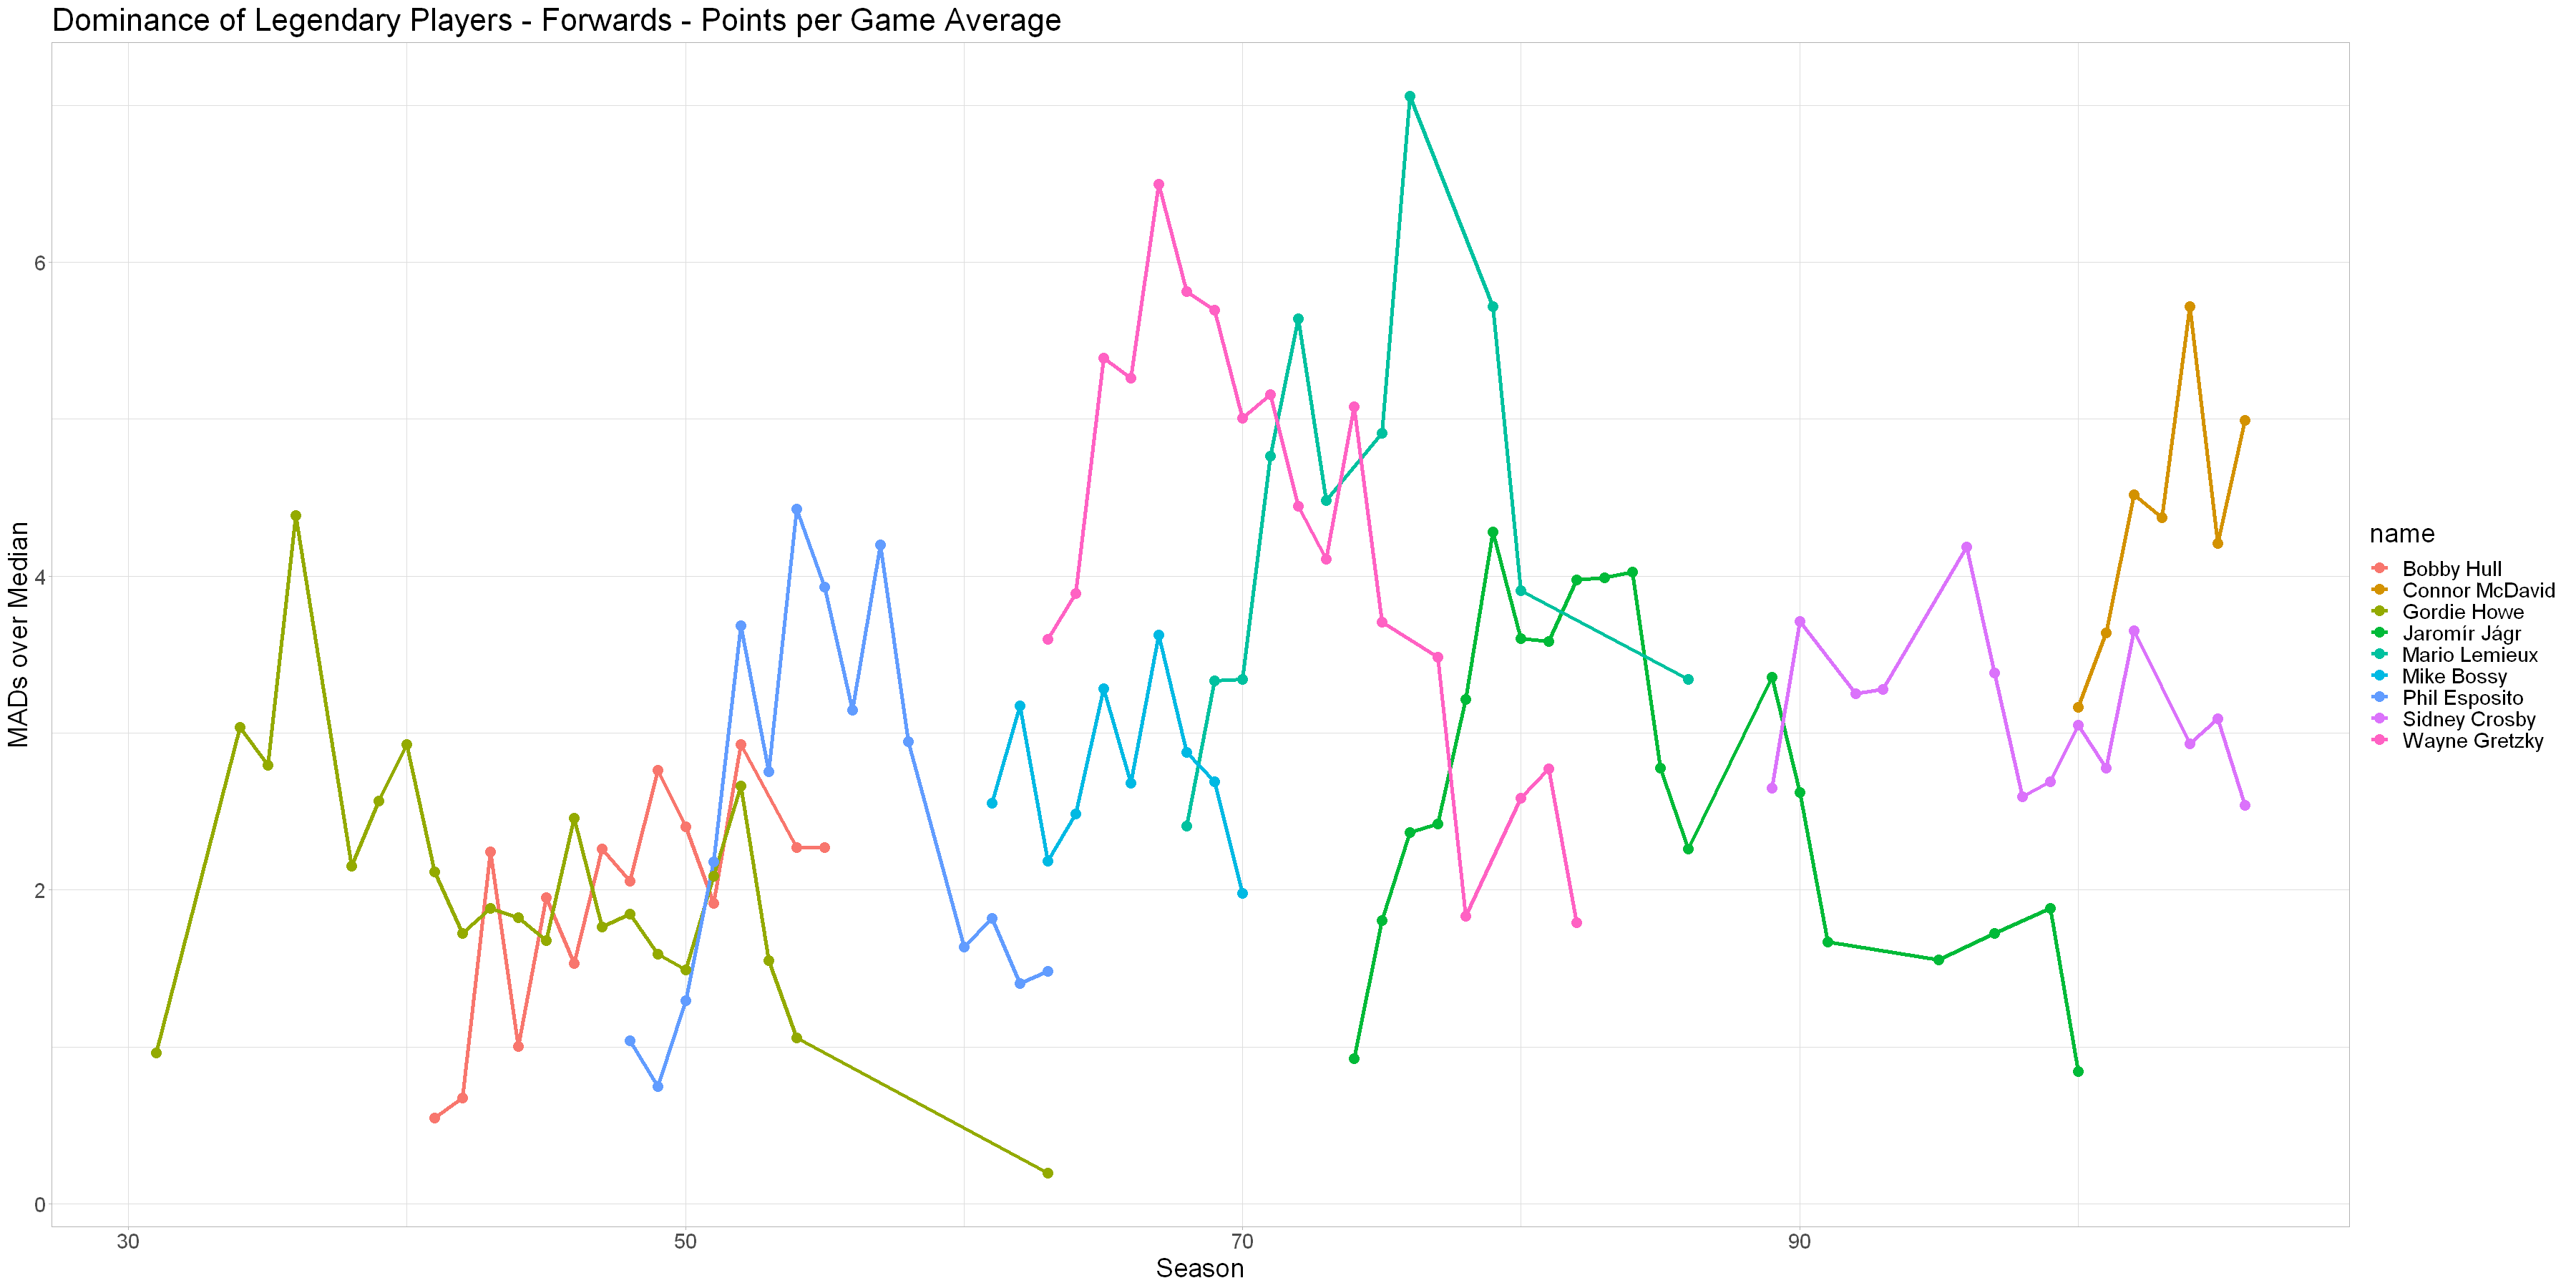

In [266]:
options(repr.plot.width=30, repr.plot.height=15)
forward_legends <- c("Mario Lemieux", "Wayne Gretzky", "Gordie Howe", "Connor McDavid", "Jaromír Jágr", "Sidney Crosby", "Mike Bossy", "Phil Esposito", "Bobby Hull")
dominance_p_f %>%
filter(name %in% forward_legends) %>%
ggplot(., aes(x=season_id, y=measure, colour=name, group=name)) + 
labs(title="Dominance of Legendary Players - Forwards - Points per Game Average", y="MADs over Median", x="Season") + 
geom_line(size=1.5) + 
geom_point(size=4) + 
def_plot_setup 



#### Distribution of Seasonal Goals per Game

Warning message:
"Removed 21 rows containing non-finite values (`stat_density()`)."


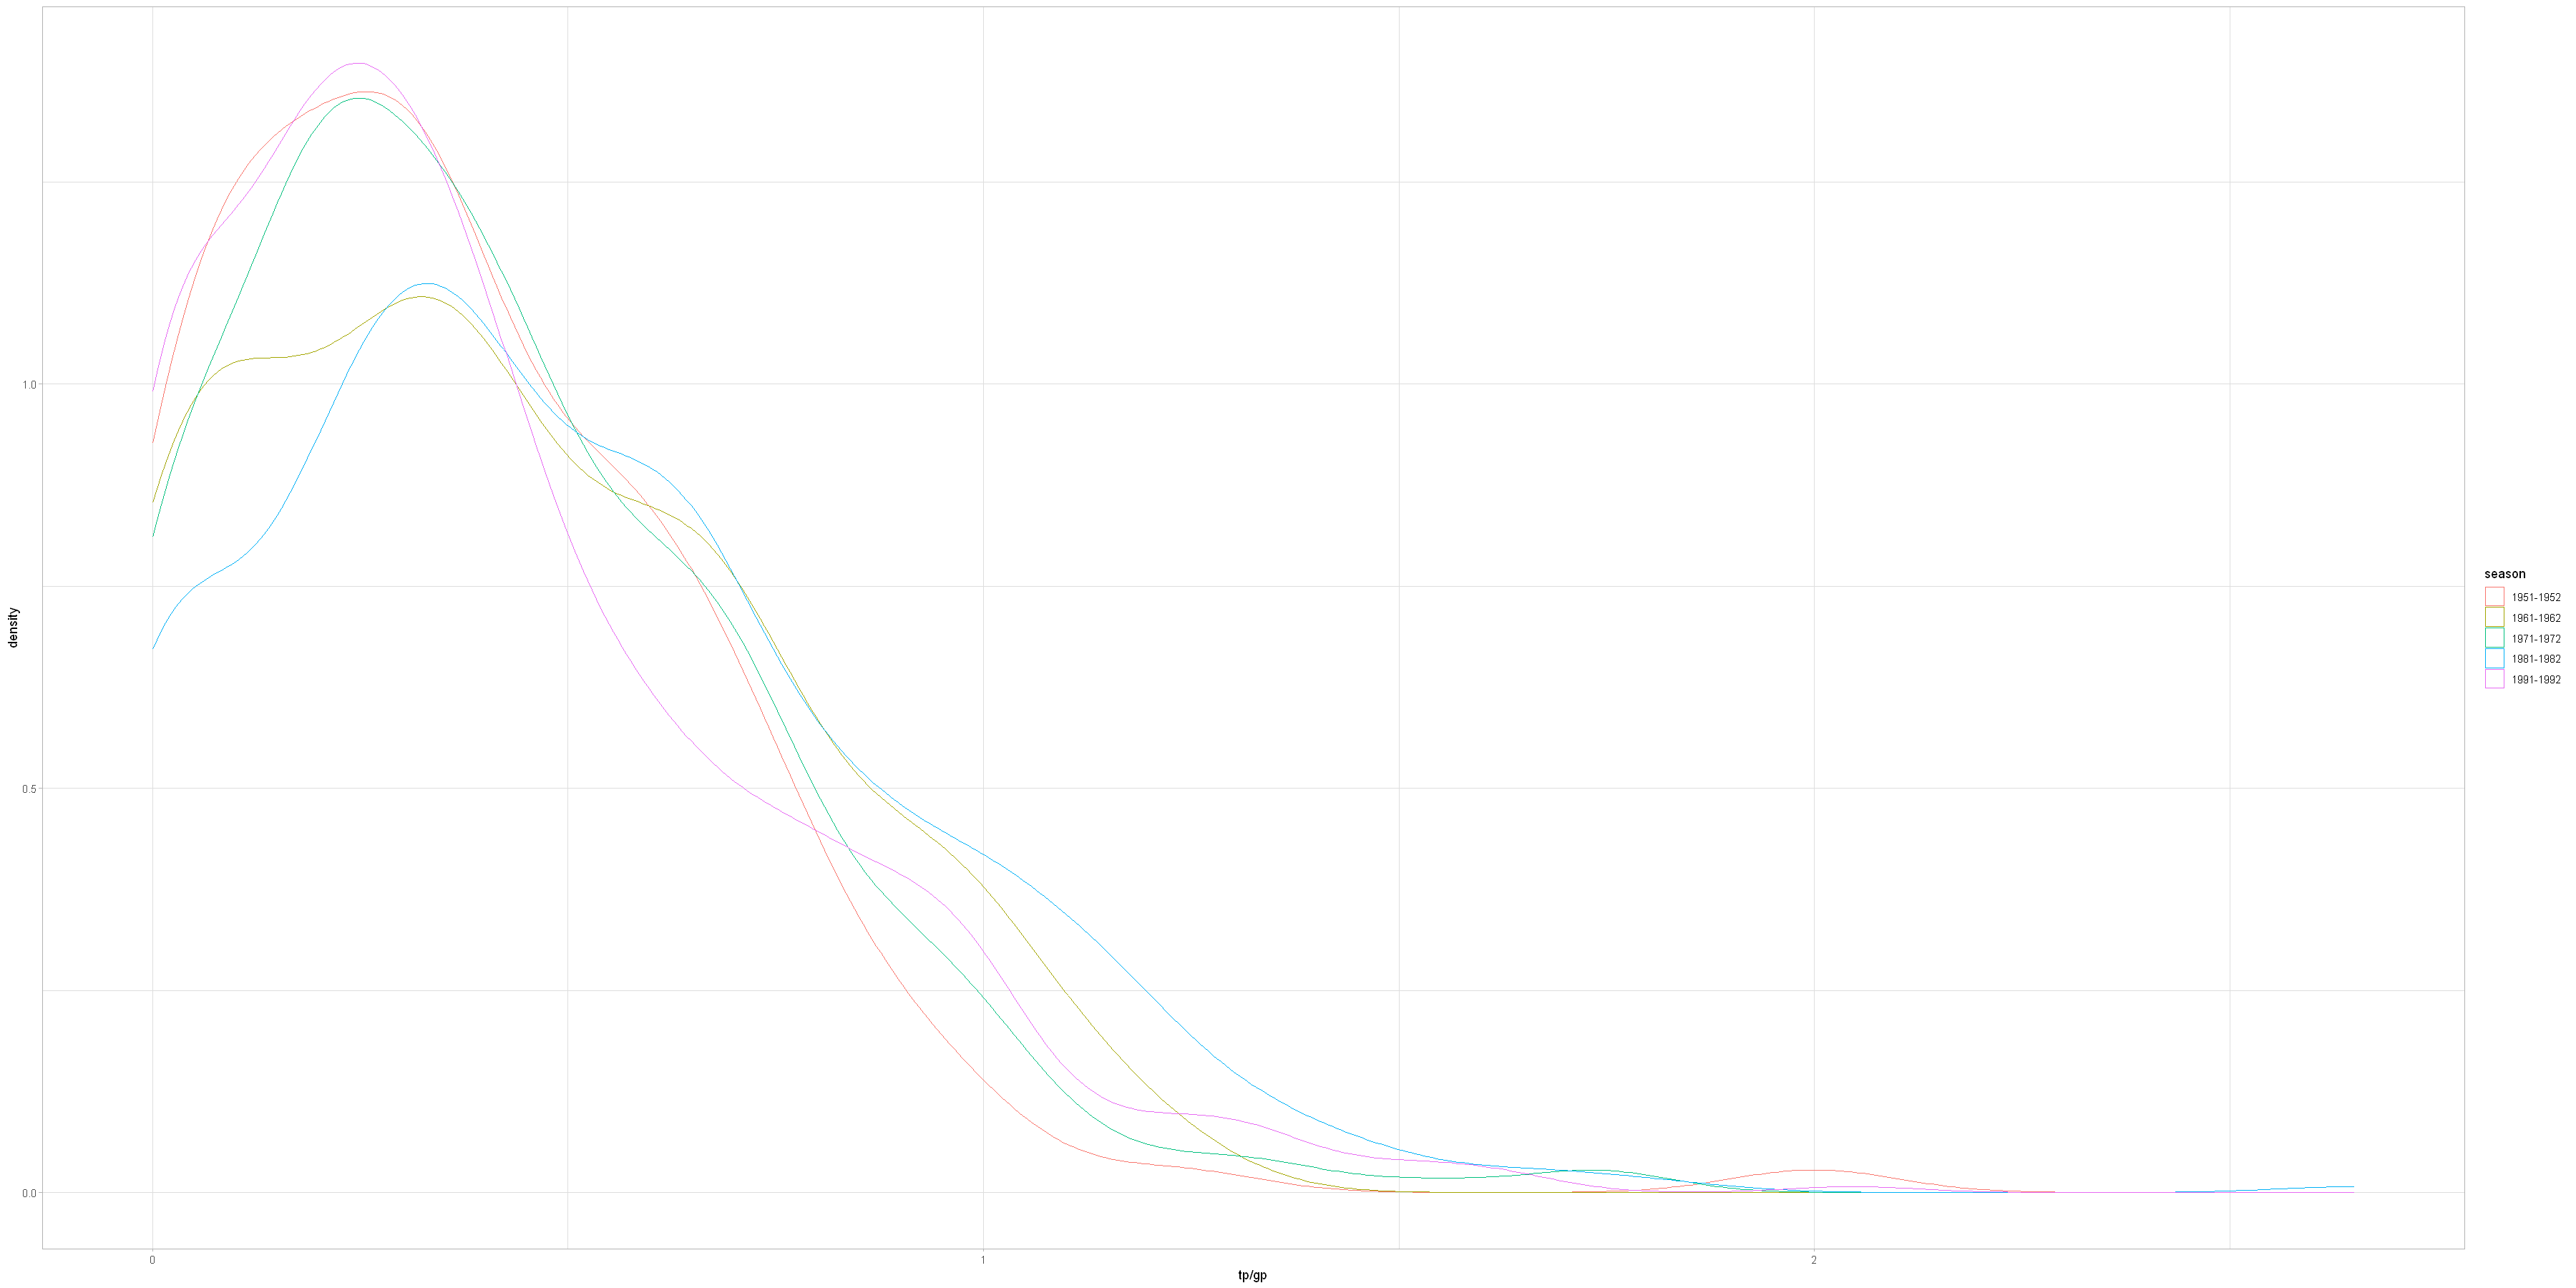

In [236]:
data %>%
filter(regular_season==1) %>%
filter(season_id %in% c(35, 45, 55, 65, 75)) %>%
ggplot(., aes( x=tp/gp, colour=season)) + 
geom_density() + 
theme_light()

#### Goals Per Game - Forwards

##### Best Seasons

In [148]:
dominance_g_f <- create_comparative_measure(data, "attack", 1, avg_g)
head(dominance_g_f, 20)

rank,name,position,active,gp,g,a,tp,plus_minus,season,team_id,nationality,avg_p,avg_g,mad,median,median_games,measure,season_id
<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Mario Lemieux,C,0,60,69,91,160,55,1992-1993,81,Canada,2.666667,1.1500000,0.1581440,0.1600000,54.0,6.260117,76
2,Babe Dye,RW,0,29,38,8,46,NA,1924-1925,144,Canada,1.586207,1.3103448,0.2081483,0.1403941,26.5,5.620756,8
3,Wayne Gretzky,C,0,74,87,118,205,78,1983-1984,66,Canada,2.770270,1.1756757,0.1732487,0.2054795,56.0,5.600021,67
4,Brett Hull,RW,0,78,86,45,131,23,1990-1991,84,USA,1.679487,1.1025641,0.1698813,0.1666667,46.0,5.509127,74
5,Alexander Mogilny,RW,0,77,76,51,127,7,1992-1993,38,Russia,1.649351,0.9870130,0.1581440,0.1600000,54.0,5.229493,76
6,Mario Lemieux,C,0,70,69,92,161,10,1995-1996,81,Canada,2.300000,0.9857143,0.1627244,0.1585366,49.0,5.083305,79
7,Mario Lemieux,C,0,76,85,114,199,41,1988-1989,81,Canada,2.618421,1.1184211,0.1888053,0.1690141,49.0,5.028498,72
8,Wayne Gretzky,C,0,80,92,120,212,80,1981-1982,66,Canada,2.650000,1.1500000,0.1944287,0.2175992,51.5,4.795593,65
9,Brett Hull,RW,0,73,70,39,109,-2,1991-1992,84,USA,1.493151,0.9589041,0.1703946,0.1549296,43.0,4.718310,75


##### Highest Career Averages

In [262]:
career_g_dominance_f <- create_career_measure(dominance_g_f)
head(career_g_dominance_f, 10)

name,measure,n
<chr>,<dbl>,<int>
Mario Lemieux,3.674784,11
Auston Matthews,3.419317,7
Alexander Ovechkin,3.304633,18
Mike Bossy,3.169135,10
Pavel Bure,3.139689,8
David Pastrnak,2.887203,7
Connor McDavid,2.864376,7
Brett Hull,2.766213,16
Steven Stamkos,2.620627,12


##### Best Players Carreer Comparison

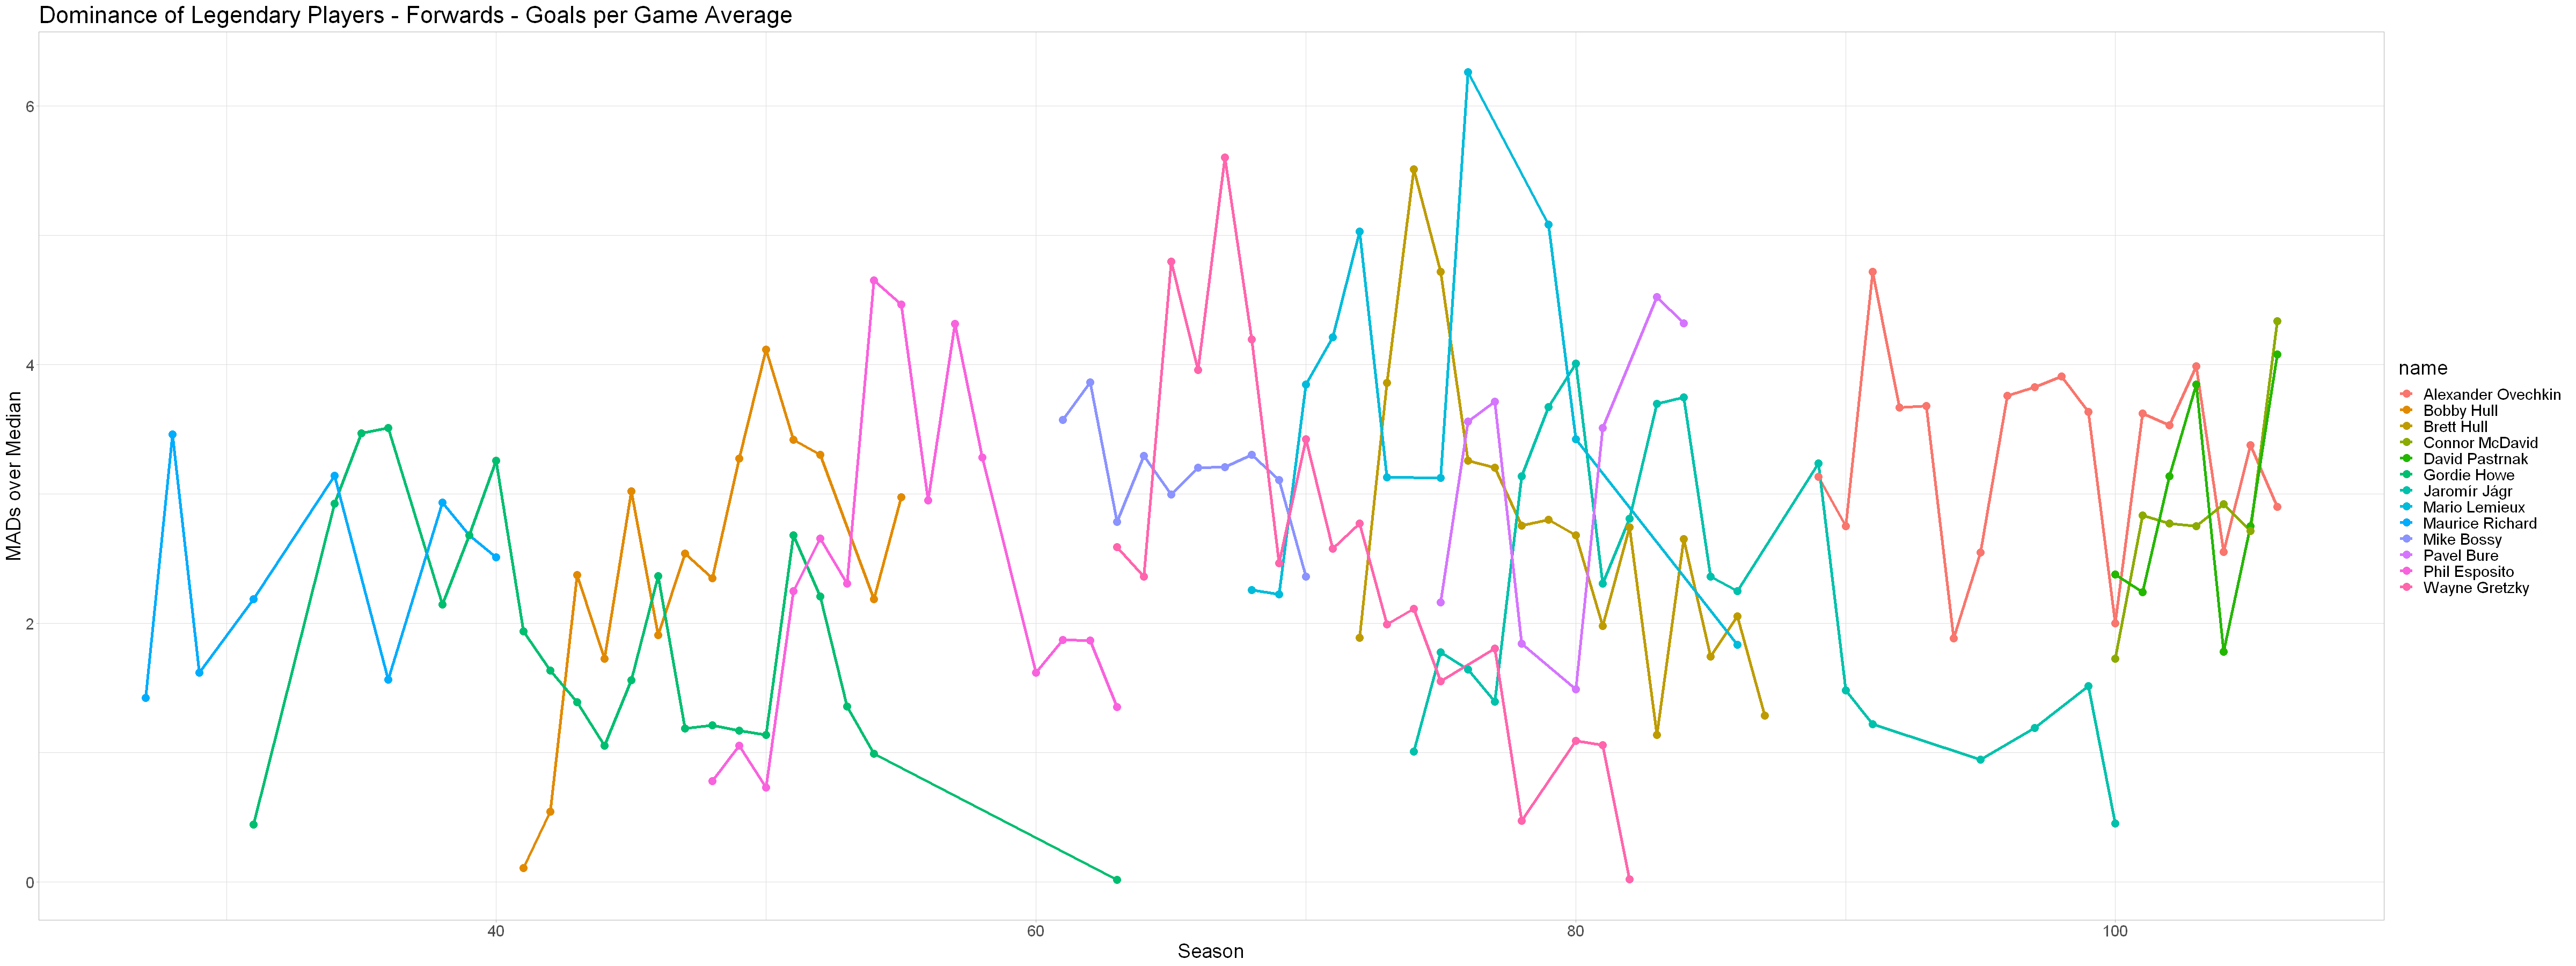

In [228]:
options(repr.plot.width=40, repr.plot.height=15)
forward_legends <- c("Mario Lemieux", "Wayne Gretzky", "Gordie Howe", "Connor McDavid", "Pavel Bure", "David Pastrnak", "Mike Bossy", "Phil Esposito", "Bobby Hull", "Alexander Ovechkin", "Brett Hull", "Maurice Richard", "Jaromír Jágr")
dominance_g_f %>%
filter(name %in% forward_legends) %>%
ggplot(., aes(x=season_id, y=measure, colour=name, group=name)) + 
labs(title="Dominance of Legendary Players - Forwards - Goals per Game Average", y="MADs over Median", x="Season") + 
geom_line(size=1.5) + 
geom_point(size=4)  + 
def_plot_setup 

#### Goals Per Game - Defenders

##### Best Seasons

In [190]:
dominance_p_d <- create_comparative_measure(data, "defense", 1, avg_p)
head(dominance_p_d, 10)

rank,name,position,active,gp,g,a,tp,plus_minus,season,team_id,nationality,avg_p,avg_g,mad,median,median_games,measure,season_id
<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Bobby Orr,D,0,74,32,90,122,84,1973-1974,137,Canada,1.648649,0.4324324,0.1684773,0.2500000,60.0,8.301705,57
2,Bobby Orr,D,0,63,29,72,101,56,1972-1973,137,Canada,1.603175,0.4603175,0.1742705,0.2500000,62.5,7.764793,56
3,Bobby Orr,D,0,80,46,89,135,80,1974-1975,137,Canada,1.687500,0.5750000,0.1824738,0.2773504,59.0,7.727954,58
4,Bobby Orr,D,0,76,33,87,120,54,1969-1970,137,Canada,1.578947,0.4342105,0.1820737,0.2118590,56.0,7.508435,53
5,Bobby Orr,D,0,78,37,102,139,124,1970-1971,137,Canada,1.782051,0.4743590,0.2182182,0.2380952,57.0,7.075286,54
6,Dit Clapper,D/F,0,44,41,20,61,NA,1929-1930,137,Canada,1.386364,0.9318182,0.1762178,0.1975610,39.5,6.746212,13
7,Erik Karlsson,D,1,82,25,76,101,-26,2022-2023,55,Sweden,1.231707,0.3048780,0.1520615,0.2307692,46.0,6.582454,106
8,Bobby Orr,D,0,76,37,80,117,86,1971-1972,137,Canada,1.539474,0.4868421,0.2188461,0.2241852,54.5,6.010107,55
9,Cale Makar,D,1,60,17,49,66,16,2022-2023,5137,Canada,1.100000,0.2833333,0.1520615,0.2307692,46.0,5.716309,106


##### Highest Career Averages

In [191]:
career_p_dominance_d <- create_career_measure(dominance_p_d)
head(career_p_dominance_d, 10)

name,measure,n
<chr>,<dbl>,<int>
Bobby Orr,6.316375,8
Paul Coffey,3.960283,15
Raymond Bourque,3.495245,21
Erik Karlsson,3.481266,13
Brian Leetch,3.440680,13
Al MacInnis,3.364472,17
Denis Potvin,3.338673,14
Roman Josi,3.070142,11
Sergei Zubov,2.989638,13


##### Comaprison of Legendary Players

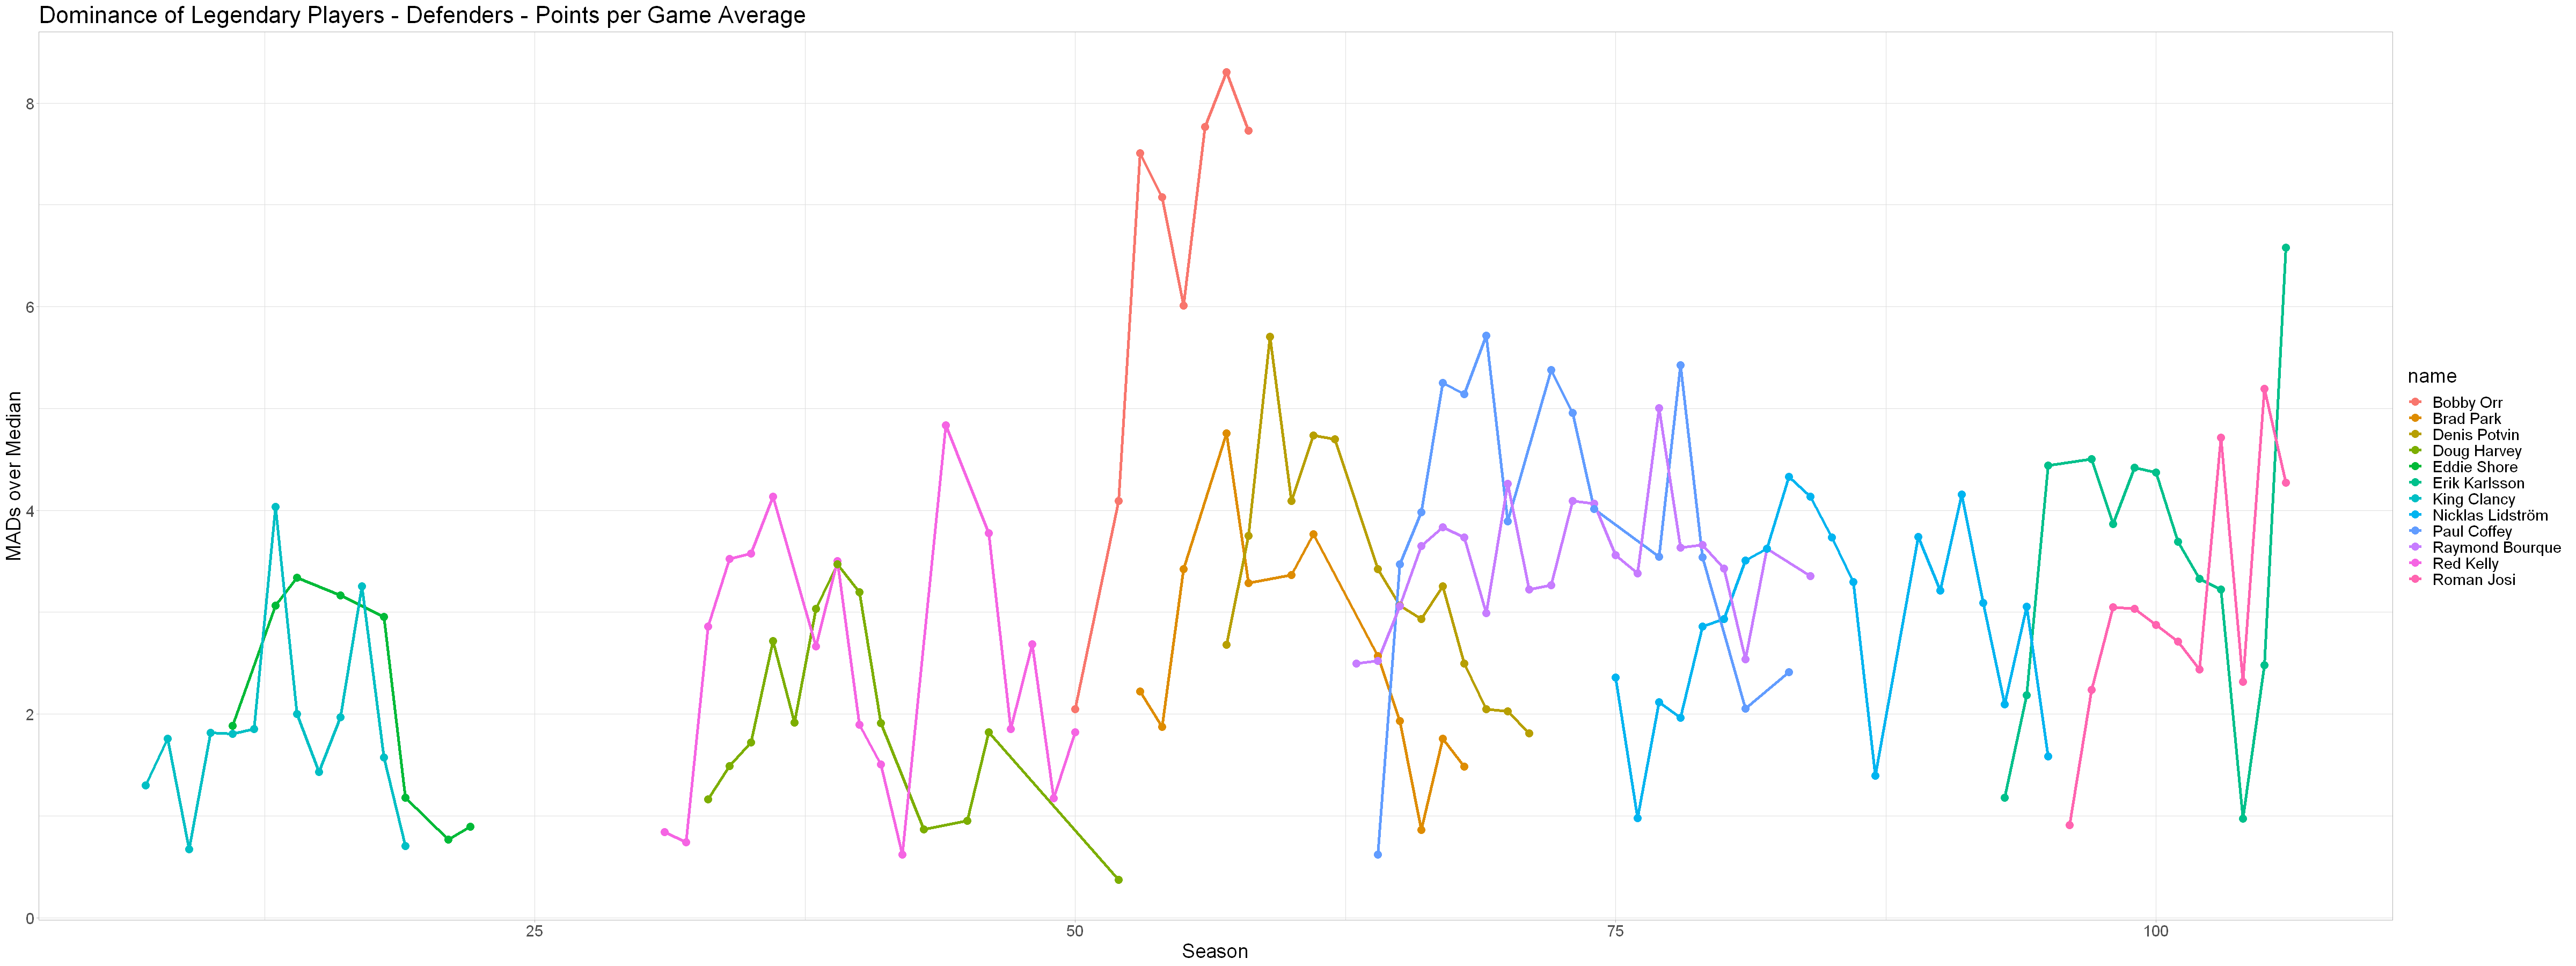

In [227]:
options(repr.plot.width=40, repr.plot.height=15)
defense_legends <- c("Bobby Orr", "Paul Coffey", "Raymond Bourque", "Erik Karlsson", "Denis Potvin", "Roman Josi", "Red Kelly", "Nicklas Lidström", "Doug Harvey", "King Clancy", "Eddie Shore", "Brad Park")
dominance_p_d %>%
filter(name %in% defense_legends) %>%
ggplot(., aes(x=season_id, y=measure, colour=name, group=name)) + 
labs(title="Dominance of Legendary Players - Defenders - Points per Game Average", y="MADs over Median", x="Season") + 
geom_line(size=1.5) + 
geom_point(size=4) + 
def_plot_setup 

#### Goals Per Game - Defenders

##### Best Seasons

In [267]:
dominance_g_d <- create_comparative_measure(data, "defense", 1, avg_g)
head(dominance_g_d, 10)

rank,name,position,active,gp,g,a,tp,plus_minus,season,team_id,nationality,avg_p,avg_g,mad,median,median_games,measure,season_id
<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Doug Mohns,LW/D,0,70,22,27,49,NA,1965-1966,163,Canada,0.7000000,0.3142857,0.02316562,0.01562500,46.0,12.892409,49
2,Dit Clapper,D/F,0,44,41,20,61,NA,1929-1930,137,Canada,1.3863636,0.9318182,0.07990636,0.08001422,39.5,10.660027,13
3,Bobby Orr,D,0,76,33,87,120,54,1969-1970,137,Canada,1.5789474,0.4342105,0.04266696,0.02877847,56.0,9.502249,53
4,Sergei Gonchar,D,0,53,21,10,31,1,1998-1999,39,Russia,0.5849057,0.3962264,0.04061918,0.02739726,46.0,9.080173,82
5,Bobby Orr,D,0,80,46,89,135,80,1974-1975,137,Canada,1.6875000,0.5750000,0.06177500,0.04166667,59.0,8.633482,58
6,Dit Clapper,D/F,0,48,17,8,25,NA,1936-1937,137,Canada,0.5208333,0.3541667,0.03901579,0.02631579,39.0,8.403031,20
7,Mike Green,D,0,68,31,42,73,24,2008-2009,39,Canada,1.0735294,0.4558824,0.05202105,0.03508772,52.0,8.088930,92
8,Bobby Orr,D,0,76,37,80,117,86,1971-1972,137,Canada,1.5394737,0.4868421,0.05816354,0.03923077,54.5,7.695738,55
9,Baldy Northcott,D/LW,0,46,15,14,29,NA,1936-1937,145,Canada,0.6304348,0.3260870,0.03901579,0.02631579,39.0,7.683330,20


##### Highest Career Averages

In [268]:
career_g_dominance_d <- create_career_measure(dominance_g_d)
head(career_g_dominance_d, 10)

name,measure,n
<chr>,<dbl>,<int>
Bobby Orr,6.568746,8
Baldy Northcott,3.798623,9
Paul Coffey,3.687214,15
Red Kelly,3.616186,17
Denis Potvin,3.569438,14
Dit Clapper,3.466639,15
Al MacInnis,3.302296,17
Doug Mohns,3.281146,17
Guy Lapointe,3.234358,8


##### Comparison of Legendary Players

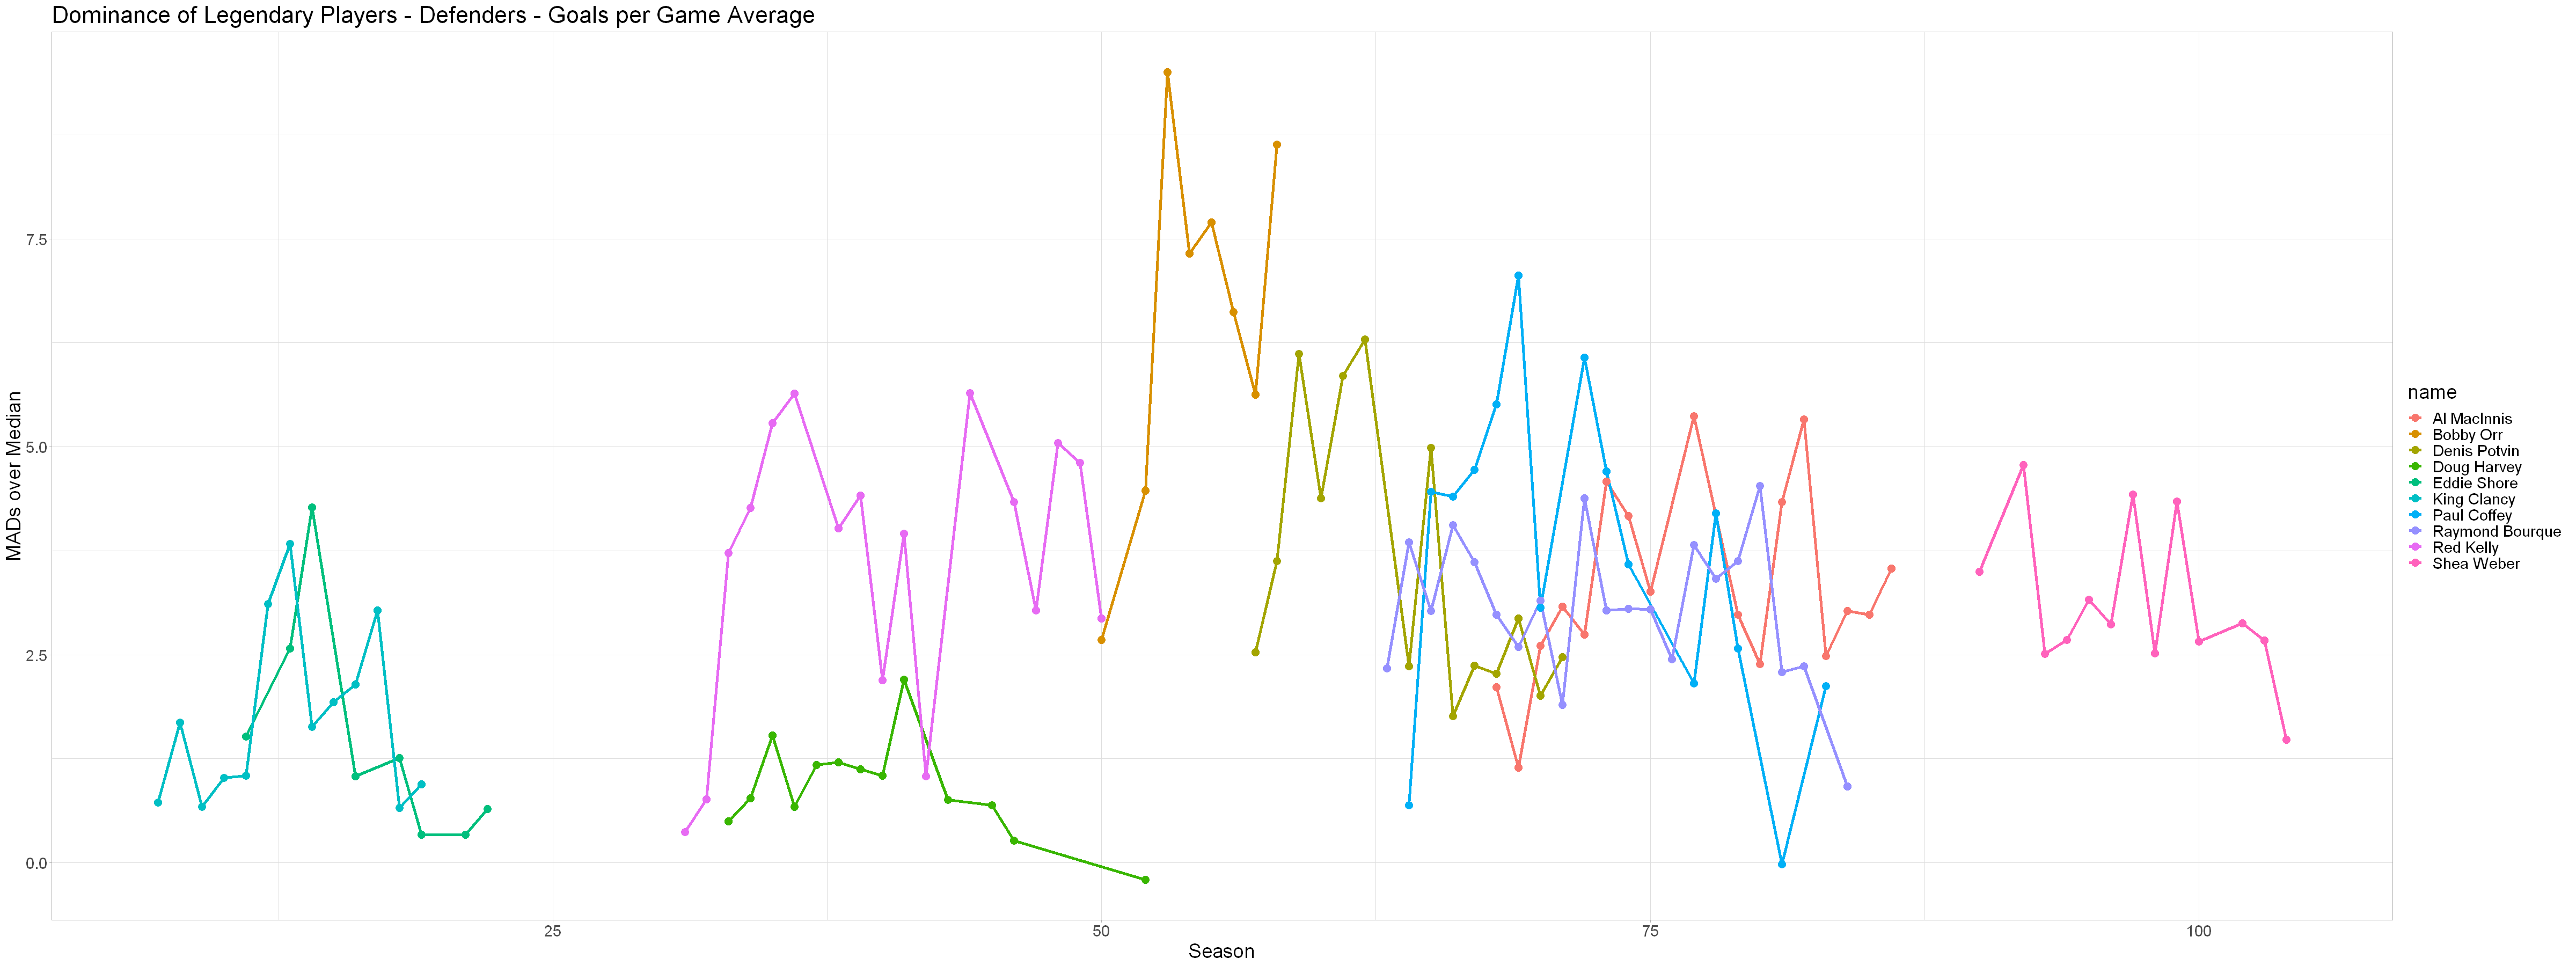

In [226]:
options(repr.plot.width=40, repr.plot.height=15)
defense_legends <- c("Bobby Orr", "Paul Coffey", "Raymond Bourque", "Shea Weber", "Denis Potvin", "Al MacInnis", "Red Kelly", "Doug Harvey", "King Clancy", "Eddie Shore")
dominance_g_d %>%
filter(name %in% defense_legends) %>%
ggplot(., aes(x=season_id, y=measure, colour=name, group=name)) + 
labs(title="Dominance of Legendary Players - Defenders - Goals per Game Average", y="MADs over Median", x="Season") + 
geom_line(size=1.5) + 
geom_point(size=4) + 
def_plot_setup 

#### Plus Minus - Defenders

##### Best Seasons

In [269]:
dominance_ps_d <- create_comparative_measure(data, "defense", 1, plus_minus)
head(dominance_ps_d, 10)

rank,name,position,active,gp,g,a,tp,plus_minus,season,team_id,nationality,avg_p,avg_g,mad,median,median_games,measure,season_id
<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Mark Howe,D,0,77,24,58,82,85,1985-1986,61,USA,1.0649351,0.31168831,8.8956,0,46.5,9.555286,69
2,Brad McCrimmon,D,0,80,13,43,56,83,1985-1986,61,Canada,0.7000000,0.16250000,8.8956,0,46.5,9.330456,69
3,Bobby Orr,D,0,78,37,102,139,124,1970-1971,137,Canada,1.7820513,0.47435897,13.3434,0,57.0,9.292984,54
4,Vladimir Konstantinov,D,0,81,14,20,34,60,1995-1996,87,Russia,0.4197531,0.17283951,7.4130,0,49.0,8.093889,79
5,Chris Pronger,D,0,81,9,27,36,47,1997-1998,84,Canada,0.4444444,0.11111111,5.9304,0,50.0,7.925266,81
6,Mark Howe,D,0,69,15,43,58,57,1986-1987,61,USA,0.8405797,0.21739130,7.4130,-1,55.0,7.824093,70
7,Brian Engblom,D,0,76,4,29,33,78,1981-1982,50,Canada,0.4342105,0.05263158,10.3782,-1,47.0,7.612110,65
8,Larry Robinson,D,0,77,19,66,85,120,1976-1977,50,Canada,1.1038961,0.24675325,16.3086,-2,55.0,7.480716,60
9,Scott Stevens,D,0,83,18,60,78,53,1993-1994,3364,Canada,0.9397590,0.21686747,7.4130,-1,48.0,7.284500,77


##### Highest Career Averages

In [270]:
career_ps_dominance_d <- create_career_measure(dominance_ps_d)
head(career_ps_dominance_d, 10)

name,measure,n
<chr>,<dbl>,<int>
Vladimir Konstantinov,4.155613,6
Mark Howe,3.428807,11
Charlie McAvoy,3.365300,6
Brad McCrimmon,3.293613,16
Larry Robinson,3.288850,19
Nicklas Lidström,3.194276,20
Raymond Bourque,2.973571,21
Matt Grzelcyk,2.891113,6
Craig Muni,2.825367,9


Warning message:
"Removed 1 row containing missing values (`geom_line()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."


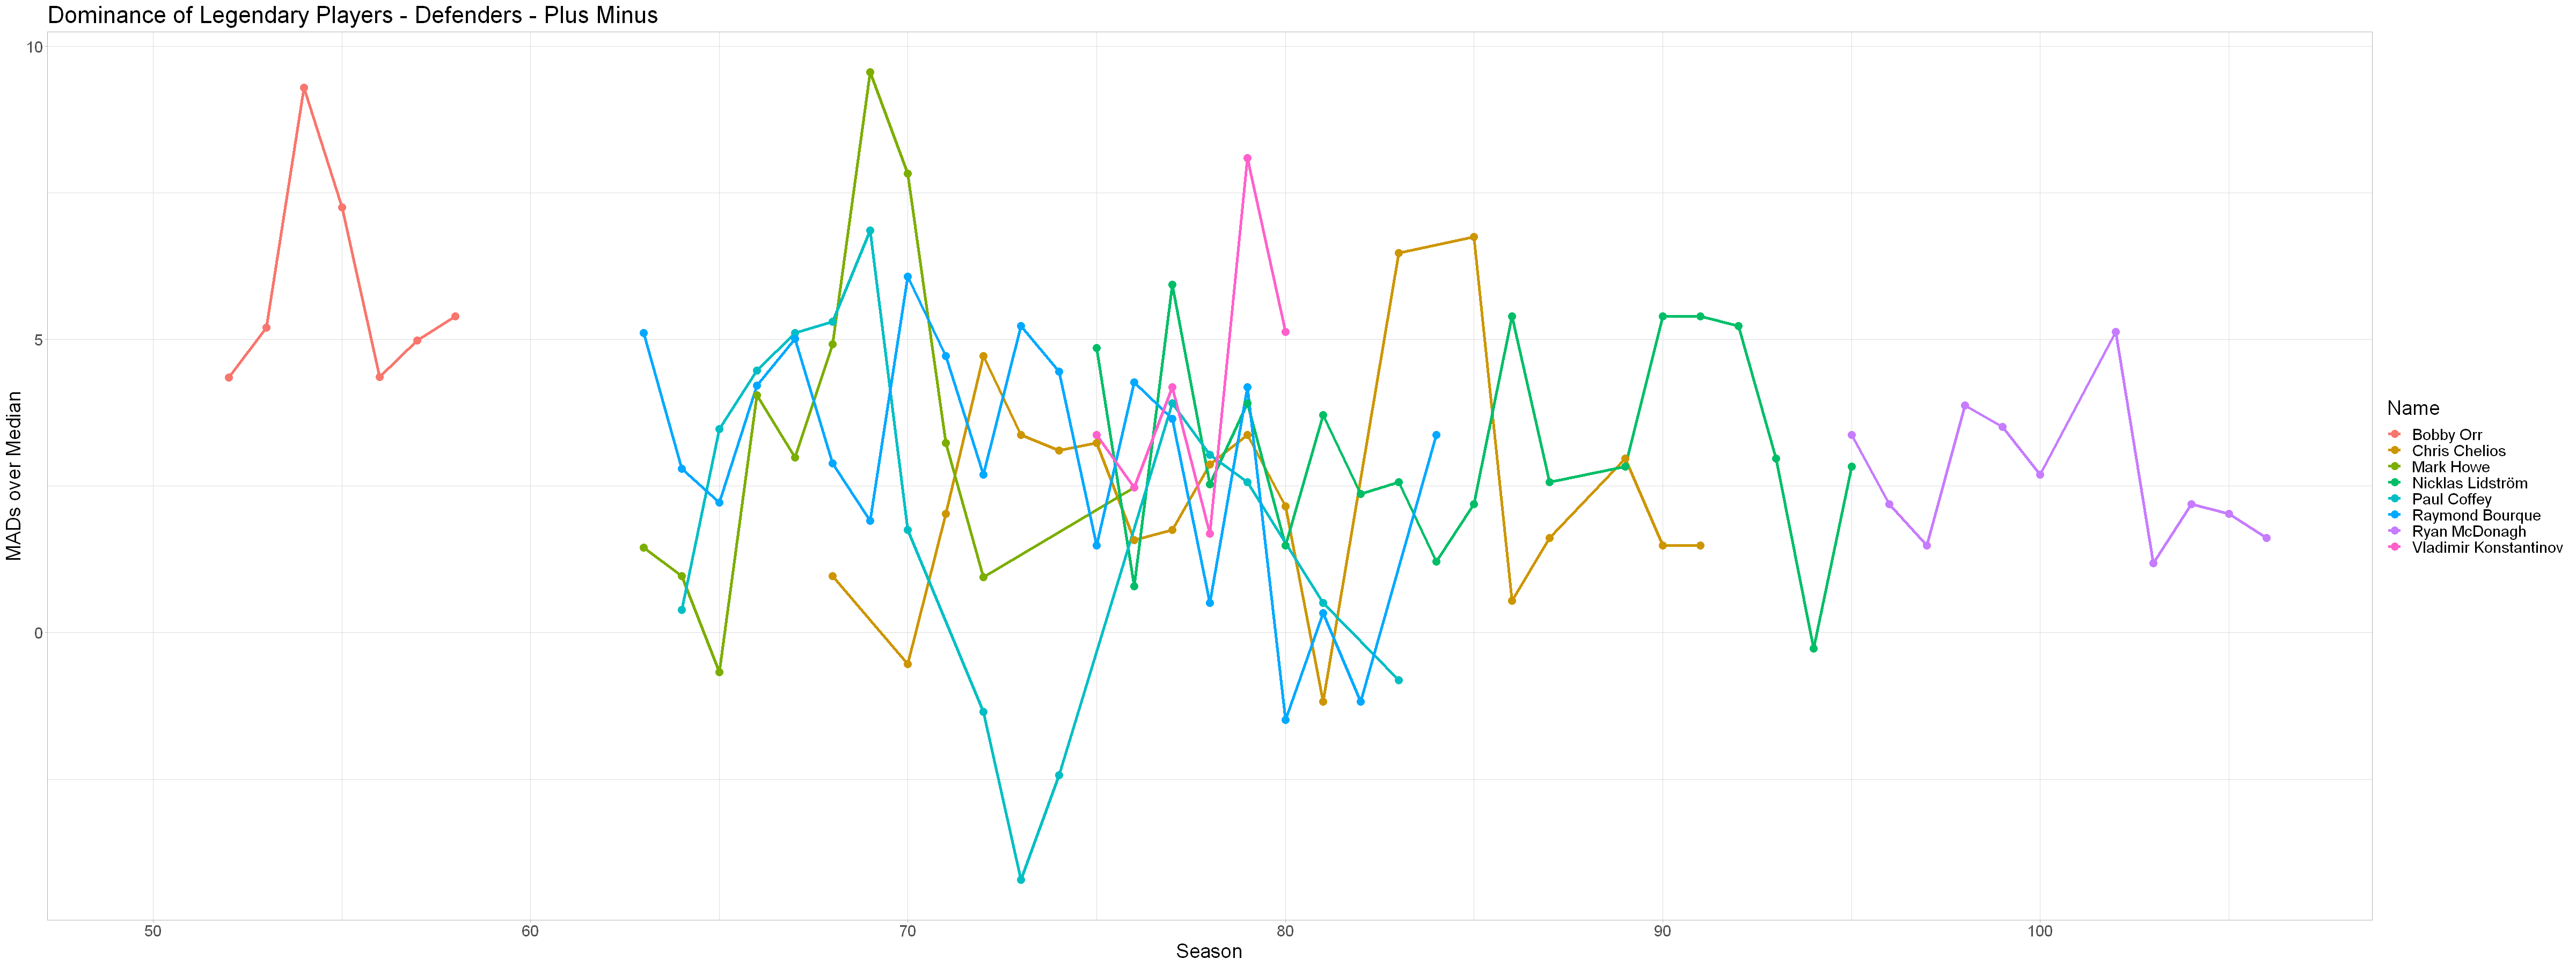

In [225]:
options(repr.plot.width=40, repr.plot.height=15)
defense_legends <- c("Bobby Orr", "Paul Coffey", "Raymond Bourque", "Vladimir Konstantinov", "Mark Howe", "Nicklas Lidström", "Chris Chelios", "Ryan McDonagh")
dominance_ps_d %>%
filter(name %in% defense_legends) %>%
ggplot(., aes(x=season_id, y=measure, colour=name, group=name)) + 
labs(title="Dominance of Legendary Players - Defenders - Plus Minus", y="MADs over Median", x="Season", colour="Name") + 
geom_line(size=1.5) + 
geom_point(size=4) + 
def_plot_setup 

### Points per Game vs. Plus Minus

In [319]:
cum_sum_tp <- player_data %>%
filter(regular_season==1) %>%
group_by(name, season_id) %>%
summarize(tp=sum(tp)) 
player_data %>%
filter(name=="Jaromír Jágr") %>%
select(season, tp)

group_by(name) %>%
arrange(season_id) %>%
mutate(cs_tp=cumsum(tp)) 

player_data %>%
filter(name=="Jaromír Jágr") %>%
select(season_id, tp)

record_tp <- cum_sum_tp %>%
group_by(season_id) %>%
summarize(record_tp = max(cs_tp, na.rm=TRUE)) %>%
left_join(cum_sum_tp, by = join_by(record_tp==cs_tp, season_id==season_id)) %>%
select(season_id, name, record_tp, tp)

record_tp

for (ind in 2:nrow(record_tp)){
if (record_tp[ind - 1, 2] > record_tp[ind, 2]){
record_tp[ind, 3] <- record_tp[ind - 1, 3]
}
}


`summarise()` has grouped output by 'name'. You can override using the
`.groups` argument.


season,tp
<chr>,<dbl>
1990-1991,13
1990-1991,57
1991-1992,24
1991-1992,69
1992-1993,9
1992-1993,94
1993-1994,6
1993-1994,99
1994-1995,15


ERROR: Error in group_by(name): object 'name' not found


In [ ]:
|""